In [11]:
#AUTOarima supports figuring out parameters for full VARMA Model

In [12]:
## if reults of the full varma model are not good enough then 
## this can be because of the  relation in between the 2 components is not strong enough
## ARIMA can work much better in such cases

# VARMA : SET OF equations number = k
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

In [13]:
df = pd.read_csv("Data/M2SLMoneyStock.csv",index_col = 0 , parse_dates = True)
df.index.freq = 'MS'
sp = pd.read_csv("Data/PCEPersonalSpending.csv",index_col = 0 , parse_dates = True)
sp.index.freq = 'MS'

In [14]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


<Axes: xlabel='Date'>

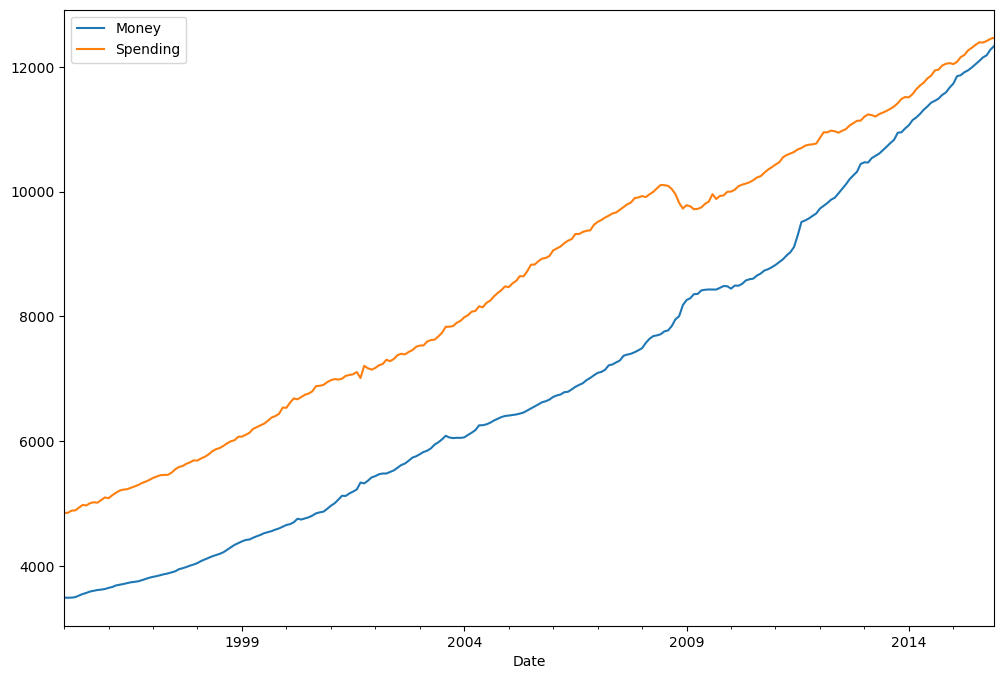

In [15]:
df.plot(figsize = (12,8),legend = True)

In [16]:
## dicky fuller to test the stationarity

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [17]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [18]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [22]:
auto_arima(df['Money'],maxiter = 1000)
## can specify maxiter to avoid termination before the divergence

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [23]:
auto_arima(df['Spending'],maxiter = 1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

In [24]:
## from this varma params are :
## p = 1 , d = 2, q = 2

In [25]:
df_transformed = df.diff().diff()

In [26]:
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


### fit arima model

In [29]:
nobs = 12

In [30]:
train = df_transformed[:-nobs] # start to end - 12
test = df_transformed[-nobs:] # start-12 to end of df

In [32]:
model = VARMAX(train, order = (1,2), trend = 'c')
# c means we want const linear trend

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [33]:
results = model.fit(maxiter= 1000)

In [34]:
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.533
,+ intercept,AIC,4607.065
Date:,"Wed, 25 Sep 2024",BIC,4666.094
Time:,19:30:13,HQIC,4630.855
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.82, 0.01",Jarque-Bera (JB):,"544.48, 117.09"
Prob(Q):,"0.37, 0.93",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.57, 2.89",Skew:,"1.34, -0.34"


In [35]:
df_forecast = results.forecast(12)

In [36]:
df_forecast

,Money,Spending
2015-01-01,-11.197677,35.820038
2015-02-01,-11.150394,-3.165618
2015-03-01,1.520244,-0.471711
2015-04-01,-1.961853,-0.043748
2015-05-01,1.385873,0.108013
2015-06-01,-0.680119,0.091966
2015-07-01,0.753695,0.119764
2015-08-01,-0.207287,0.104314
2015-09-01,0.443299,0.115402
2015-10-01,0.004138,0.108040


In [38]:
# Add the most recent first difference from the training set to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [40]:
# Add the most recent first difference from the training set to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['Spendforecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [41]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,Spendforecast
2015-01-01,-11.197677,35.820038,67.402323,11658.902323,46.420038,12108.420038
2015-02-01,-11.150394,-3.165618,56.251929,11647.751929,43.254420,12151.674458
2015-03-01,1.520244,-0.471711,57.772173,11649.272173,42.782710,12194.457167
2015-04-01,-1.961853,-0.043748,55.810320,11647.310320,42.738961,12237.196129
2015-05-01,1.385873,0.108013,57.196194,11648.696194,42.846974,12280.043103
2015-06-01,-0.680119,0.091966,56.516075,11648.016075,42.938940,12322.982043
2015-07-01,0.753695,0.119764,57.269770,11648.769770,43.058704,12366.040746
2015-08-01,-0.207287,0.104314,57.062482,11648.562482,43.163017,12409.203764
2015-09-01,0.443299,0.115402,57.505781,11649.005781,43.278419,12452.482183
2015-10-01,0.004138,0.108040,57.509919,11649.009919,43.386460,12495.868643


In [43]:
## concat with original results 
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','Spendforecast']]], axis =1)

,Money,Spending,MoneyForecast,Spendforecast
2015-01-01,11733.2,12046.0,11658.902323,12108.420038
2015-02-01,11852.4,12082.4,11647.751929,12151.674458
2015-03-01,11868.8,12158.3,11649.272173,12194.457167
2015-04-01,11916.1,12193.8,11647.310320,12237.196129
2015-05-01,11947.6,12268.1,11648.696194,12280.043103
2015-06-01,11993.1,12308.3,11648.016075,12322.982043
2015-07-01,12045.3,12355.4,11648.769770,12366.040746
2015-08-01,12096.8,12394.0,11648.562482,12409.203764
2015-09-01,12153.8,12392.8,11649.005781,12452.482183
2015-10-01,12187.7,12416.1,11649.009919,12495.868643


<Axes: xlabel='Date'>

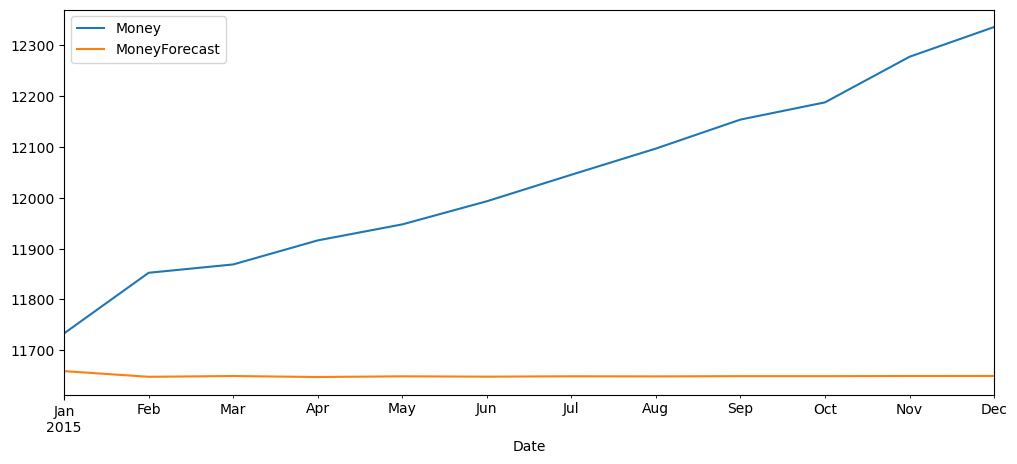

In [48]:
df['Money'][-nobs:].plot(figsize = (12,5),legend = True).autoscale(axis = 'x', tight = True)
df_forecast['MoneyForecast'].plot(legend = True)

<Axes: xlabel='Date'>

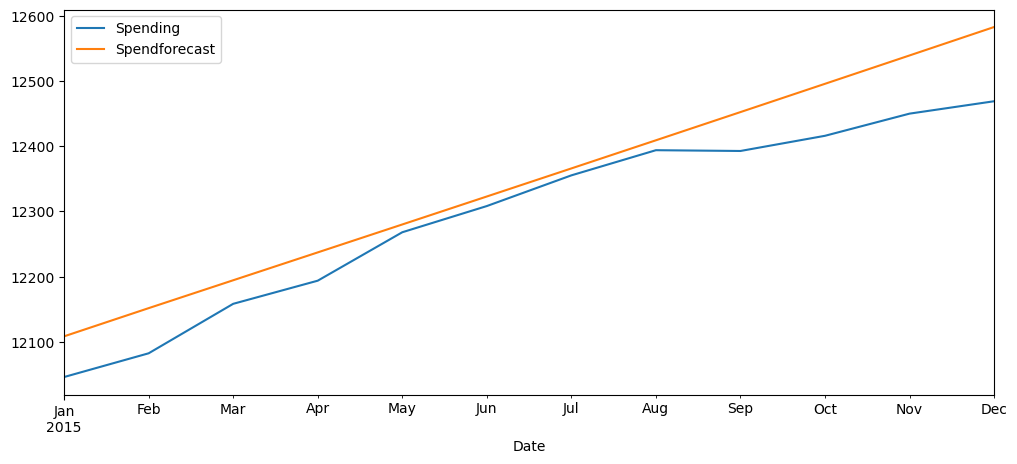

In [50]:
df['Spending'][-nobs:].plot(figsize = (12,5),legend = True).autoscale(axis = 'x', tight = True)
df_forecast['Spendforecast'].plot(legend = True)

In [52]:
test_range = df[-nobs:]

In [53]:
rmse(test_range['Money'],df_forecast['MoneyForecast'])

422.8068936688503

In [54]:
test_range['Money'].mean()

12034.008333333333

In [55]:
rmse(test_range['Spending'],df_forecast['Spendforecast'])

60.17349719627619

In [56]:
test_range['Spending'].mean()

12294.533333333335